In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [3]:
#data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
data_italy_regions_path = covid19.data.download('regioni')


In [4]:
df_italy_regions = pd.read_csv(data_italy_regions_path, parse_dates=['data'], index_col=['data'])

df_italy_regions.index = df_italy_regions.index.normalize()

REGIONS = df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)['denominazione_regione'].tolist()

print(REGIONS)

data_italy_regions = {region: df_italy_regions[df_italy_regions['denominazione_regione'] == region] for region in REGIONS}
for dr in data_italy_regions.values():
    dr['deceduti_attuali'] = dr['deceduti'].diff(1)

df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


['Lombardia', 'Emilia-Romagna', 'Piemonte', 'Veneto', 'Lazio', 'Toscana', 'Liguria', 'Marche', 'Puglia', 'Campania', 'Sicilia', 'Abruzzo', 'P.A. Trento', 'P.A. Bolzano', 'Friuli Venezia Giulia', 'Umbria', 'Calabria', 'Sardegna', "Valle d'Aosta", 'Basilicata', 'Molise']


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-04-02,Lombardia,11762,1351,7960
2020-04-02,Emilia-Romagna,3944,366,1811
2020-04-02,Piemonte,3341,453,983
2020-04-02,Veneto,1670,345,532
2020-04-02,Lazio,1169,181,185
2020-04-02,Toscana,1135,295,268
2020-04-02,Liguria,1120,172,488
2020-04-02,Marche,986,164,503
2020-04-02,Puglia,645,118,144


In [5]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())

SHOWUNTIL = np.datetime64(df_italy_regions.index.max(), 's') + 2 * DAY
print (SHOWUNTIL)

EXTENT = ('2020-02-23', SHOWUNTIL)

XLIM = tuple(map(np.datetime64, EXTENT))

2020-04-04T00:00:00


In [6]:
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': ['2020-03-06', '2020-03-21', '2020-03-27' ],
        'terapia_intensiva': 2,
        'deceduti': 4,
    },
    'Emilia-Romagna': {
        'ricoverati_con_sintomi': ['2020-03-06', '2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Piemonte': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Veneto': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Toscana': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Liguria': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Lazio': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Marche': {
        'ricoverati_con_sintomi': ['2020-03-16', '2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Puglia': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Campania': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sicilia': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'P.A. Trento': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Abruzzo': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Friuli Venezia Giulia': {
        'ricoverati_con_sintomi': ['2020-03-19', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'P.A. Bolzano': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Umbria': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Calabria': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Sardegna': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Valle d\'Aosta': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Basilicata': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
    'Molise': {
        'ricoverati_con_sintomi': ['2020-03-21', '2020-03-27'],
        'terapia_intensiva': 0,
        'deceduti': 4,
    },
}

In [7]:
region_fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    region_fits[region] = {}
    for kind, limits in params.items():
        region_fits[region][kind] = []
        if isinstance(limits, int):
            limits = [np.datetime64(d) + limits * DAY for d in params['ricoverati_con_sintomi']]
        starts = [None] + list(map(np.datetime64, limits))
        stops = [d - DAY for d in starts[1:]] + [None]
        for start, stop in zip(starts, stops):
            try:
                region_fits[region][kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[region], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

skipping: Basilicata None 2020-03-24T00:00:00


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


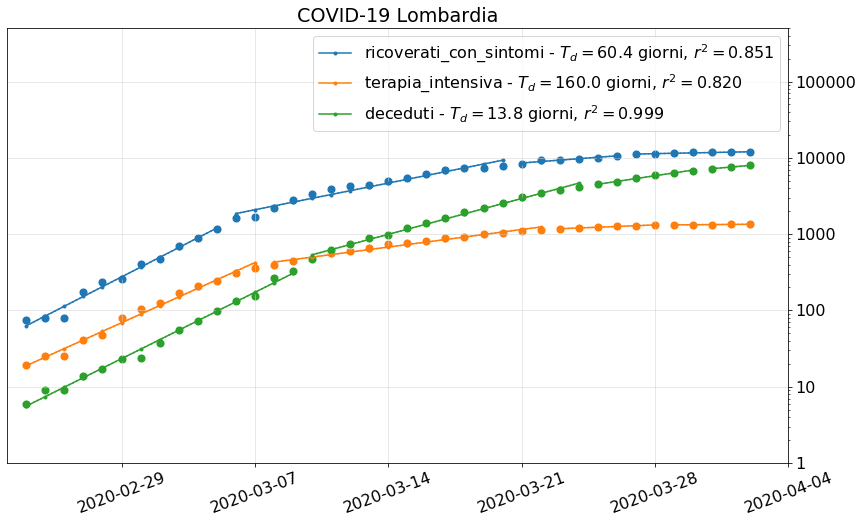

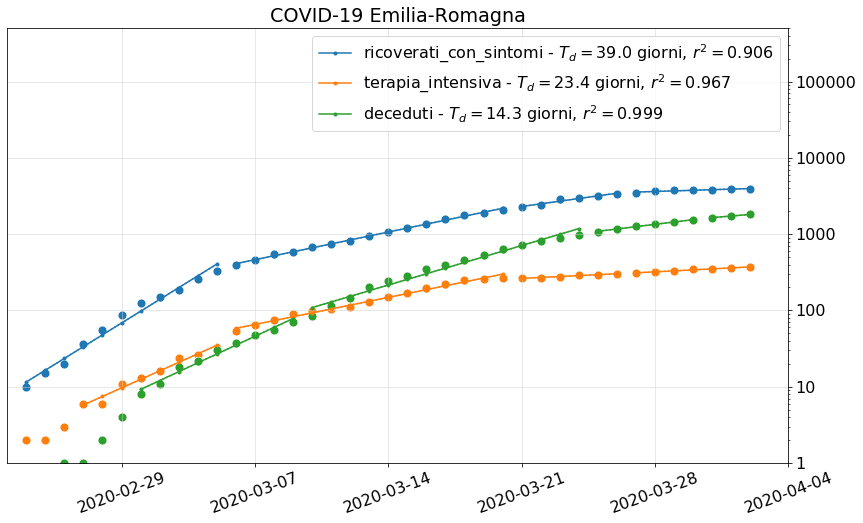

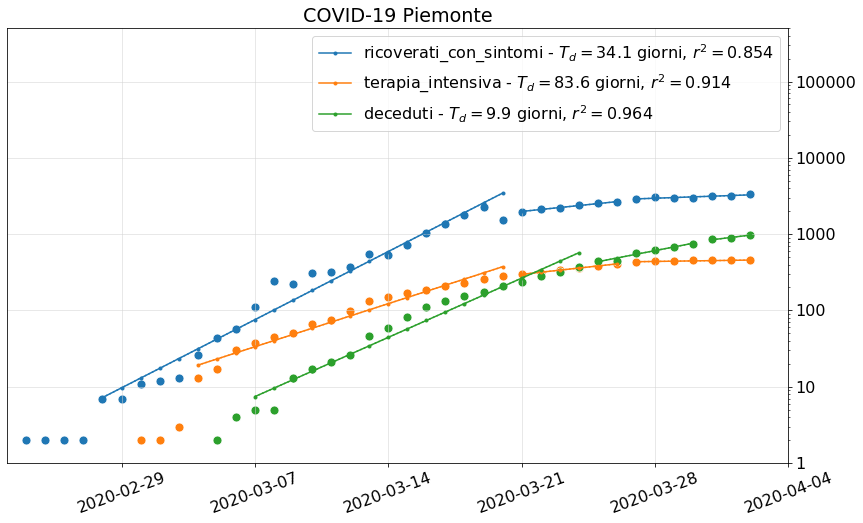

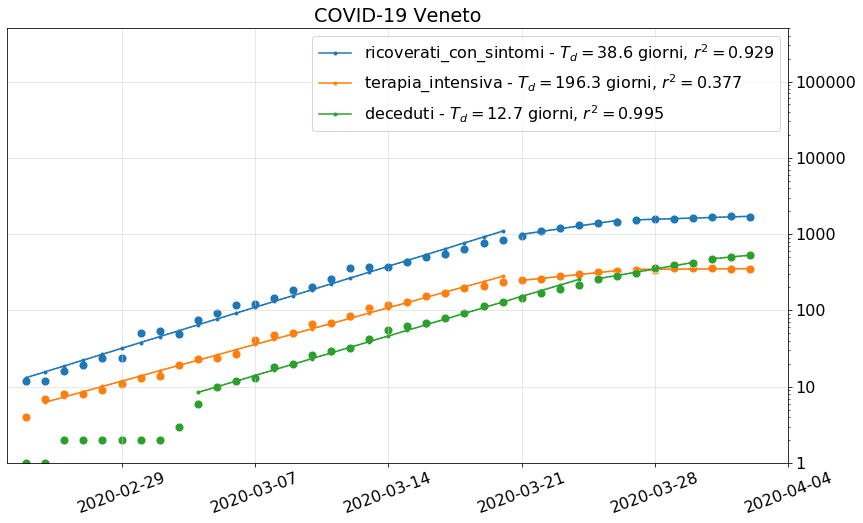

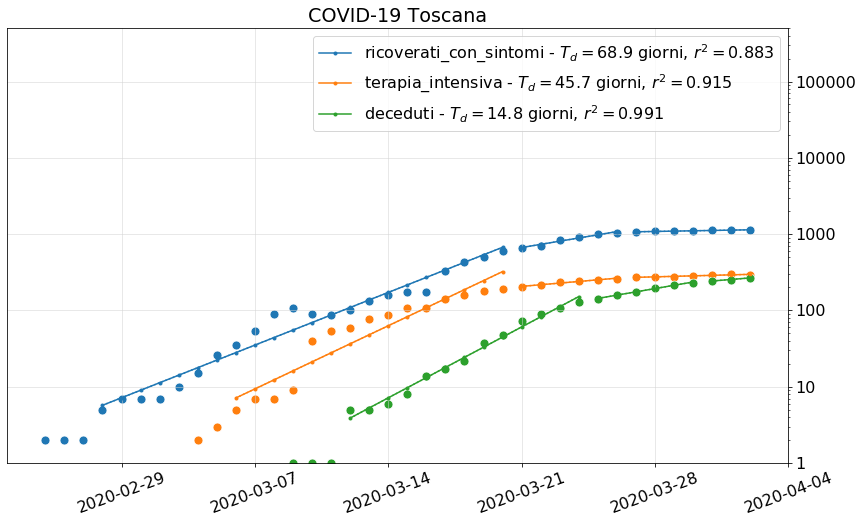

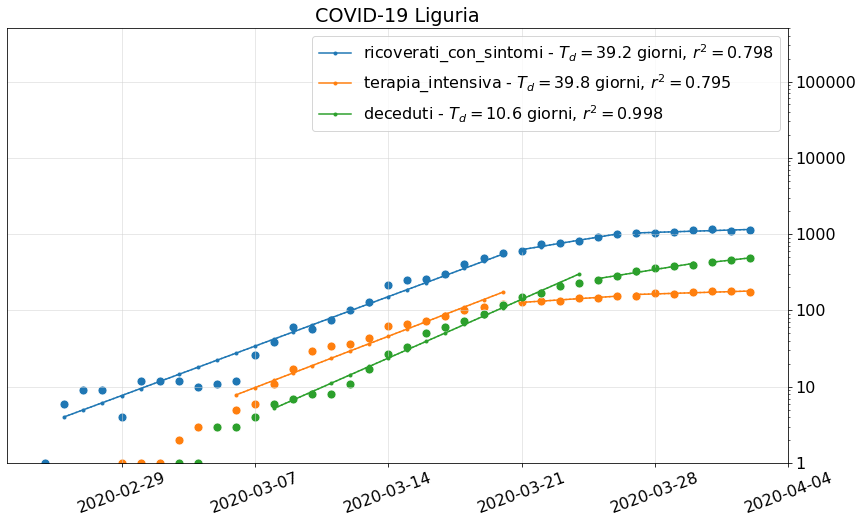

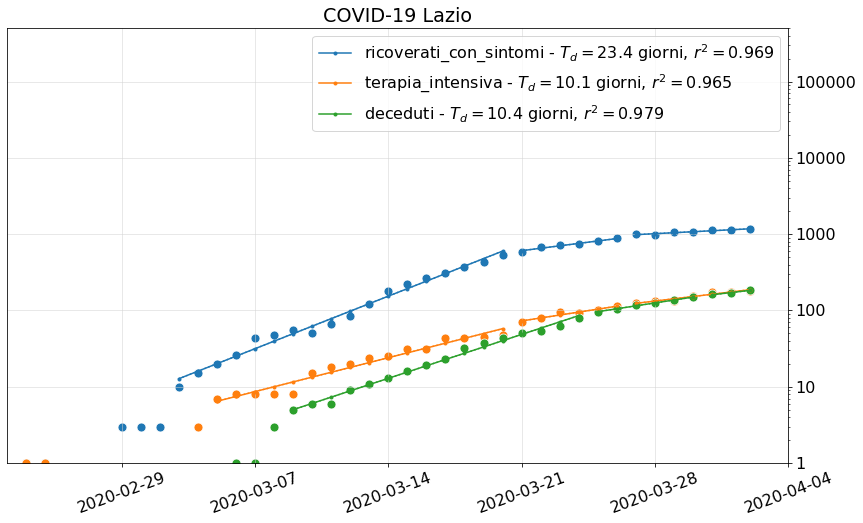

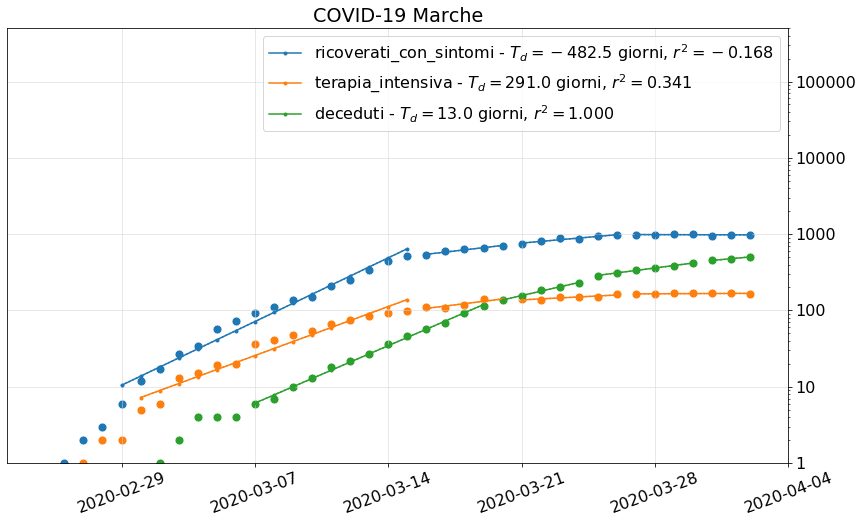

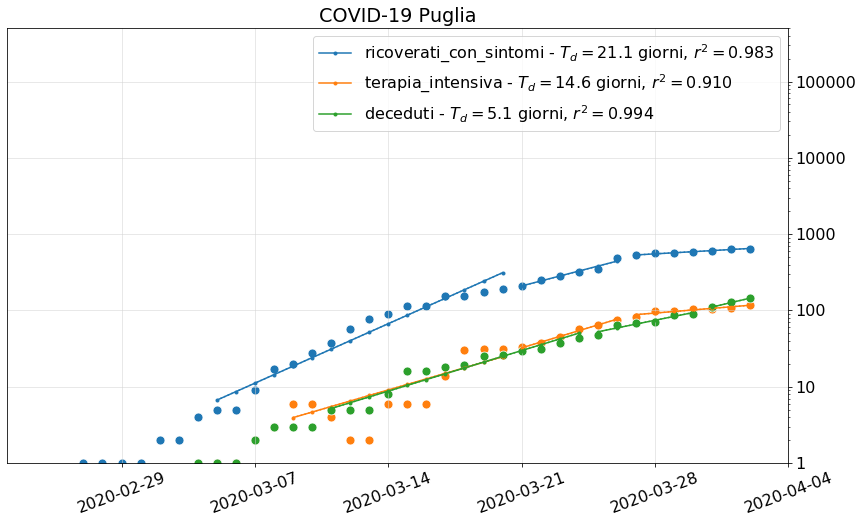

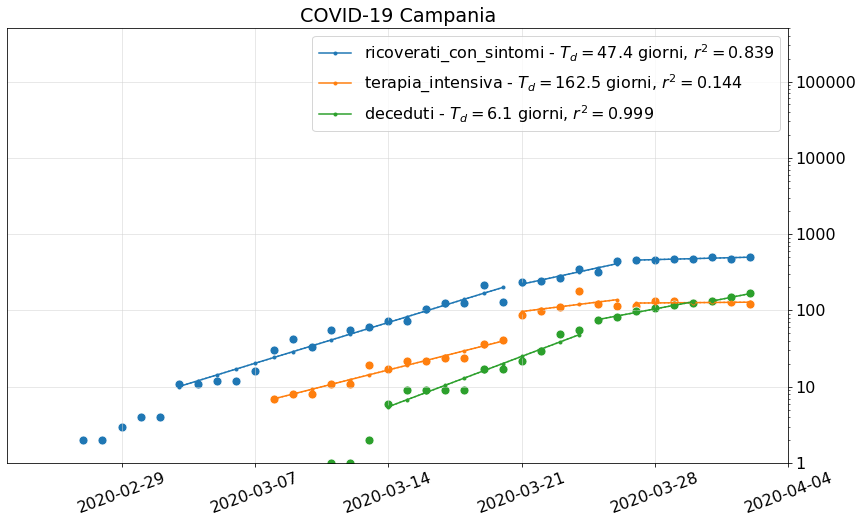

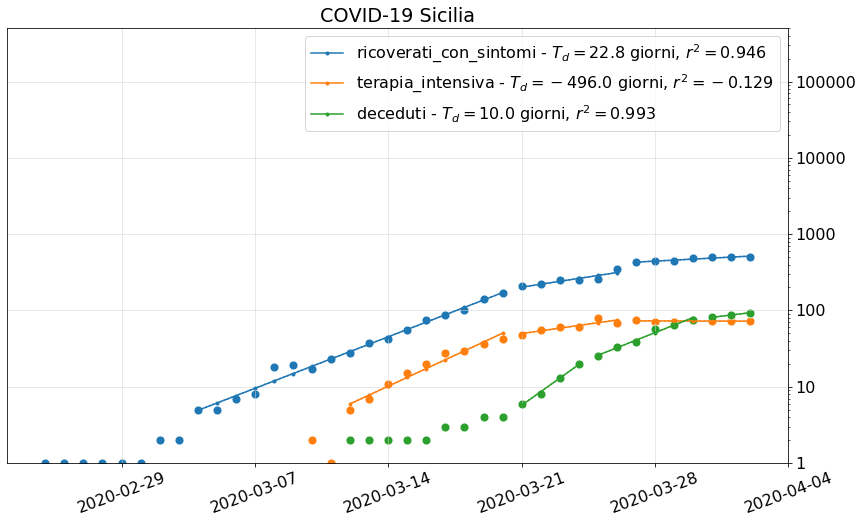

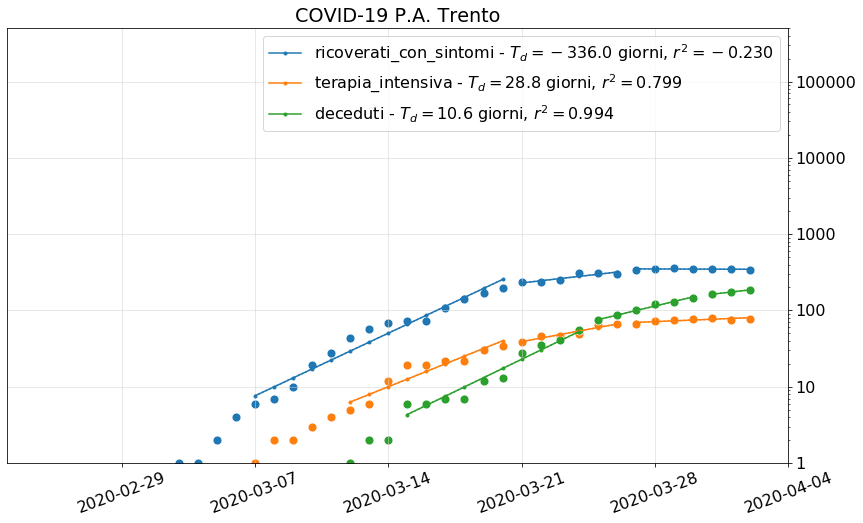

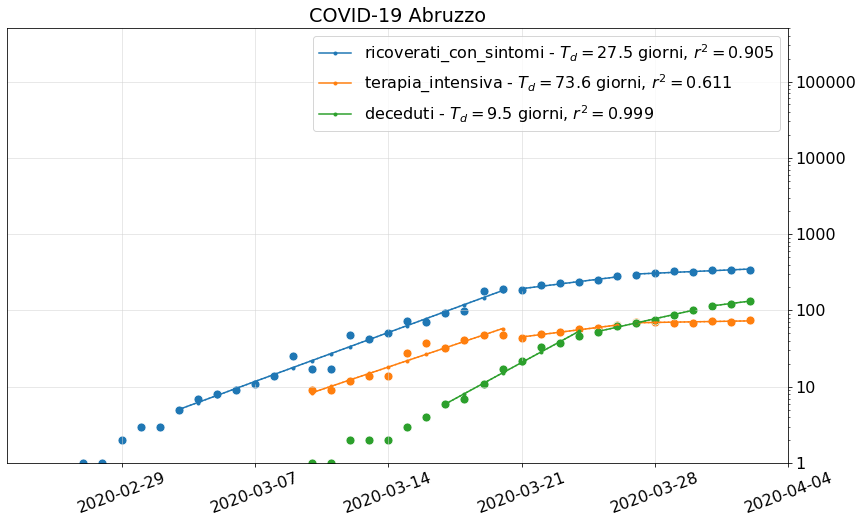

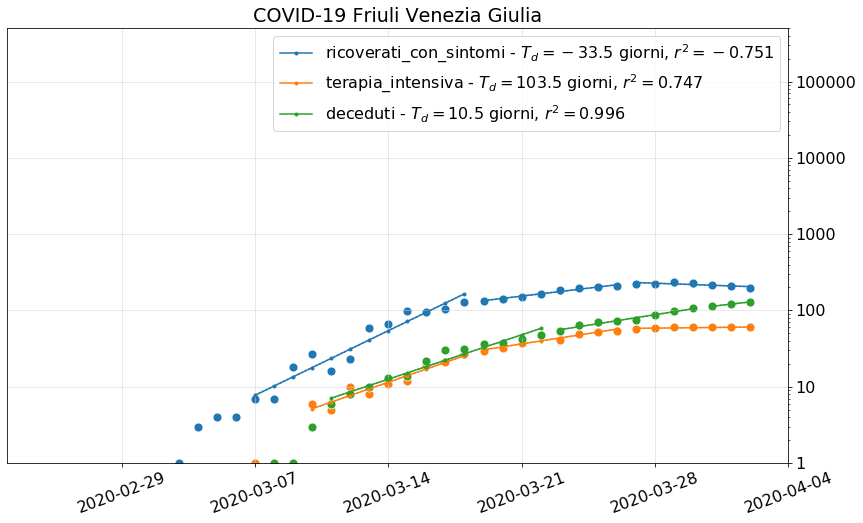

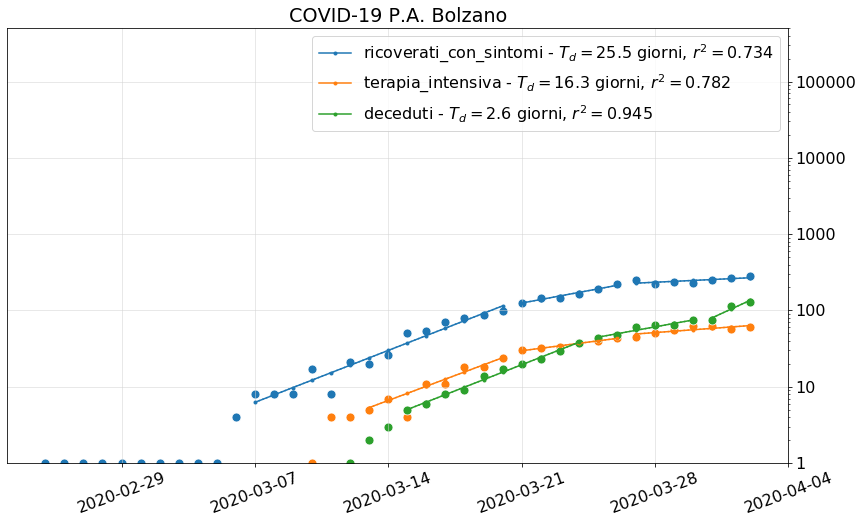

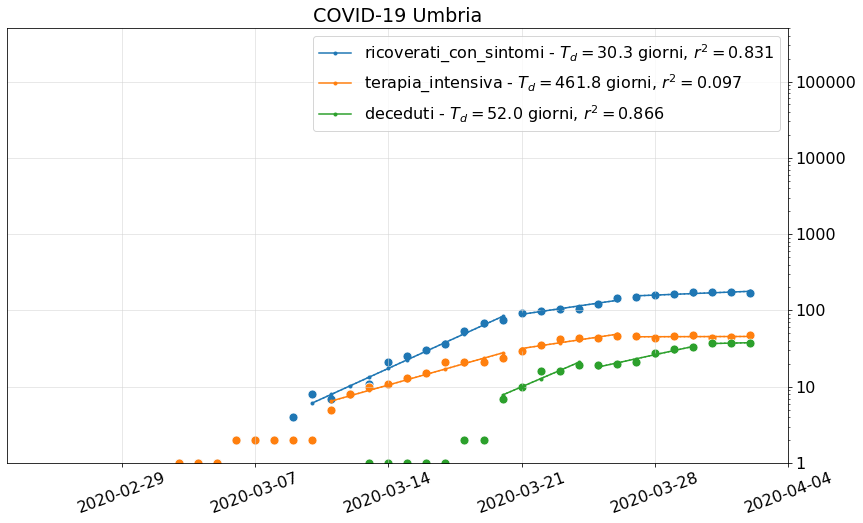

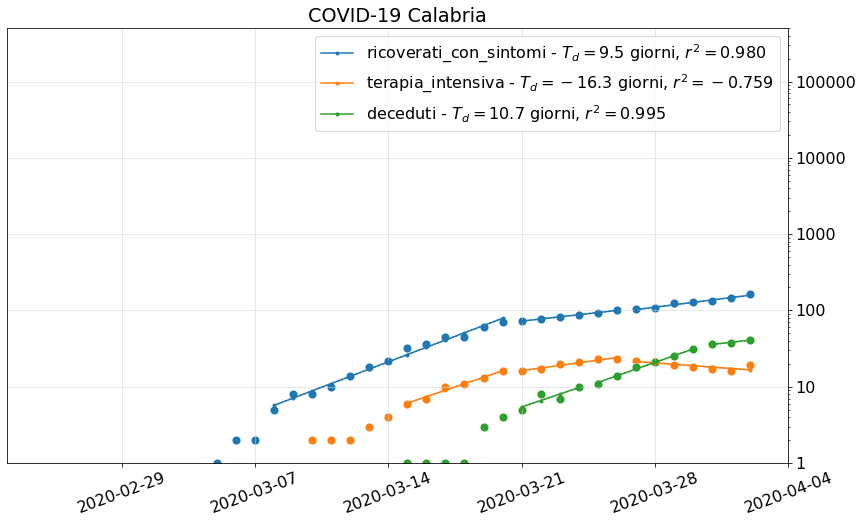

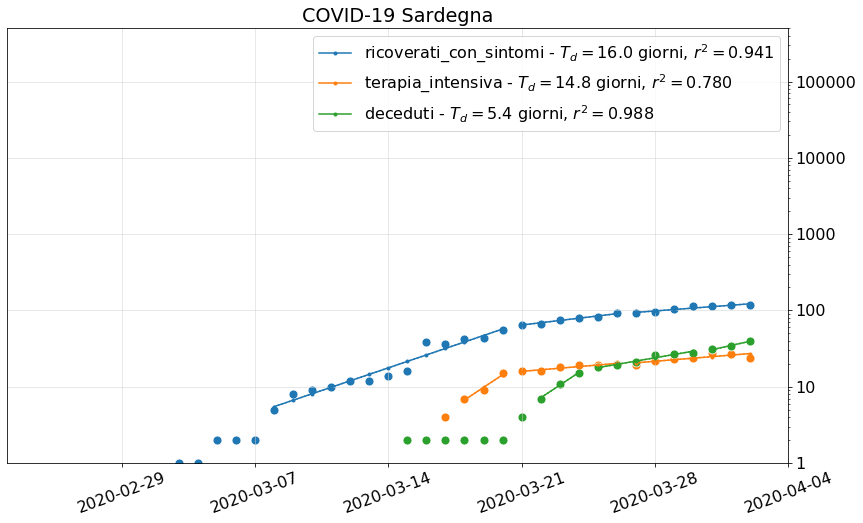

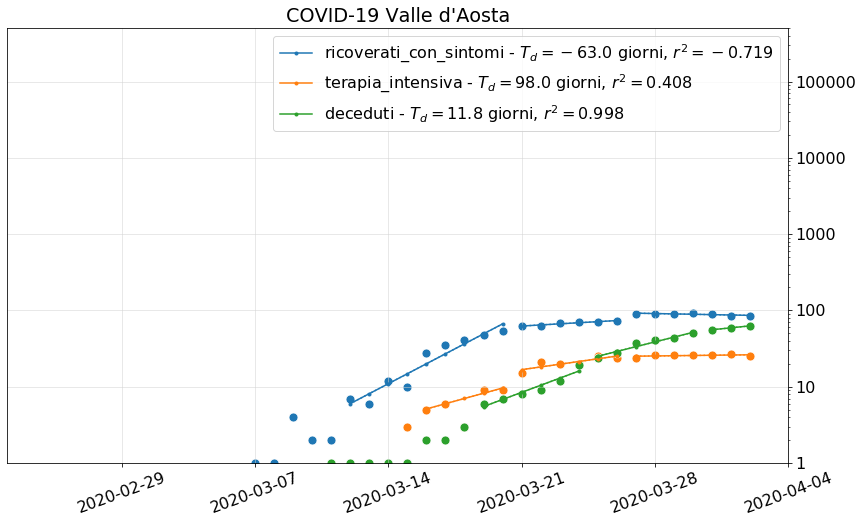

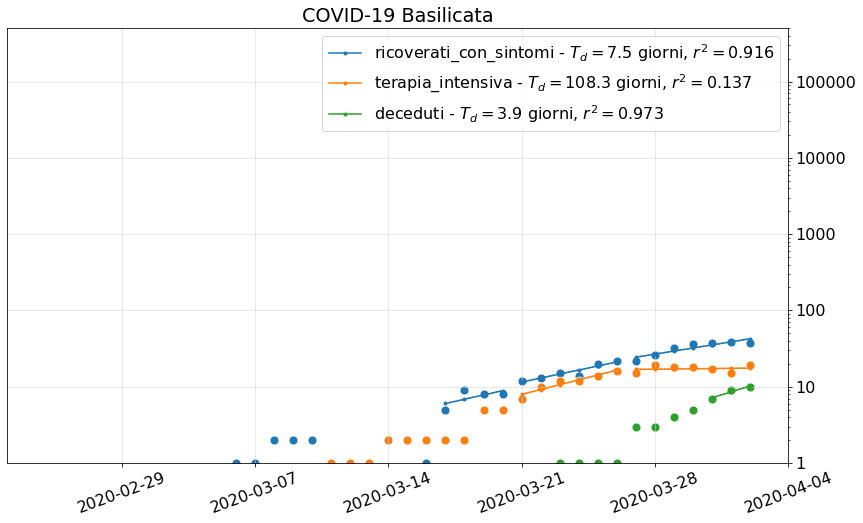

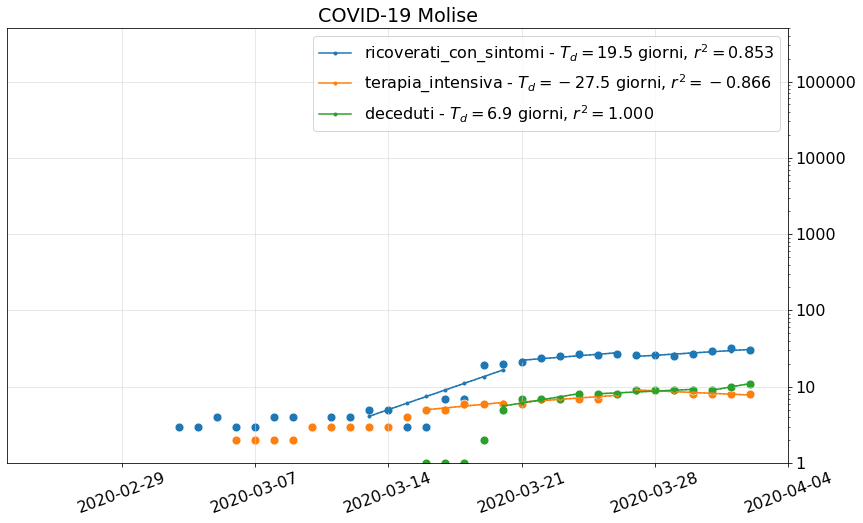

In [8]:
for region, fit_kinds in region_fits.items():
    _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (1, 500000), 'xlim': XLIM}, figsize=(14, 8))
    # _, ax = plt.subplots(subplot_kw={'yscale': 'linear', 'ylim': (1, 12500), 'xlim': XLIM}, figsize=(14, 8))
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.legend(loc='top left')

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        if kind == '':
            continue
        for fit in fits:
            # BGA to avoid all this stuff shown
            if fit == fits[-1]:
                covid19.plot.plot_fit(ax, fit, label=kind, color=color)
            else: 
                covid19.plot.plot_fit(ax, fit, color=color)
            #covid19.plot.plot_fit(ax, fit, label=kind, color=color)

        covid19.plot.plot_data(ax, data_italy_regions[region][kind], color=color, date_interval=7)

In [9]:
print('## Initial exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["deceduti"][0])}')

## Initial exponential speed
Lombardia:      T_d=2.42, t_0='2020-02-17', r^2=0.996 start='2020-02-24', stop='2020-03-09'
Emilia-Romagna: T_d=2.59, t_0='2020-02-21', r^2=0.990 start='2020-03-01', stop='2020-03-09'
Piemonte:       T_d=2.71, t_0='2020-02-28', r^2=0.976 start='2020-03-07', stop='2020-03-24'
Veneto:         T_d=4.06, t_0='2020-02-20', r^2=0.994 start='2020-03-04', stop='2020-03-24'
Toscana:        T_d=2.27, t_0='2020-03-07', r^2=0.993 start='2020-03-12', stop='2020-03-24'
Liguria:        T_d=2.74, t_0='2020-03-01', r^2=0.992 start='2020-03-08', stop='2020-03-24'
Lazio:          T_d=3.66, t_0='2020-02-29', r^2=0.995 start='2020-03-09', stop='2020-03-24'
Marche:         T_d=2.80, t_0='2020-02-28', r^2=0.999 start='2020-03-07', stop='2020-03-19'
Puglia:         T_d=3.96, t_0='2020-03-01', r^2=0.961 start='2020-03-11', stop='2020-03-24'
Campania:       T_d=3.19, t_0='2020-03-06', r^2=0.965 start='2020-03-14', stop='2020-03-24'
Sicilia:        T_d=1.69, t_0='2020-03-16', r^2=0.9

In [10]:
print('## Current exponential speed')
for region, fit_kinds in region_fits.items():
    if len(fit_kinds['deceduti']):
        print(f'{region}:{" " * (14 - len(region))} {str(fit_kinds["deceduti"][-1])}')

## Current exponential speed
Lombardia:      T_d=13.80, t_0='2019-10-06', r^2=0.999 start='2020-03-31', stop='2020-04-02'
Emilia-Romagna: T_d=14.33, t_0='2019-10-29', r^2=0.999 start='2020-03-31', stop='2020-04-02'
Piemonte:       T_d=9.85, t_0='2019-12-26', r^2=0.964 start='2020-03-31', stop='2020-04-02'
Veneto:         T_d=12.70, t_0='2019-12-09', r^2=0.995 start='2020-03-31', stop='2020-04-02'
Toscana:        T_d=14.78, t_0='2019-12-04', r^2=0.991 start='2020-03-31', stop='2020-04-02'
Liguria:        T_d=10.57, t_0='2019-12-29', r^2=0.998 start='2020-03-31', stop='2020-04-02'
Lazio:          T_d=10.44, t_0='2020-01-14', r^2=0.979 start='2020-03-31', stop='2020-04-02'
Marche:         T_d=12.97, t_0='2019-12-07', r^2=1.000 start='2020-03-31', stop='2020-04-02'
Puglia:         T_d=5.15, t_0='2020-02-25', r^2=0.994 start='2020-03-31', stop='2020-04-02'
Campania:       T_d=6.09, t_0='2020-02-17', r^2=0.999 start='2020-03-31', stop='2020-04-02'
Sicilia:        T_d=10.03, t_0='2020-01-27',